In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

In [6]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem import SmilesMolSupplier
import re

from datetime import date
import gzip
import numpy as np
pd.set_option("display.max_columns",100, "display.width",2000, "display.max_colwidth",100)
import pickle
from scipy.sparse import csr_matrix, vstack
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.utils import class_weight
from termcolor import colored
from sklearn.model_selection import train_test_split
import sklearn.metrics

import optuna
optuna.logging.set_verbosity(optuna.logging.WARN) #INFO, WARN
import lightgbm as lgb; lgb.__version__

import pickle

/Users/divyanori/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'3.2.1'

Training Analysis

In [80]:
def visualize_loss(convergence_log_file):
    data = []
    with open(convergence_log_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            lst = line.split(',')
            lst[-1] = lst[-1][:-1]
            data.append(lst)
    df = pd.DataFrame(data)
    df = df.rename(columns=df.iloc[0])
    df = df.drop(0)
    df.columns = df.columns.str.strip()
    df["epoch"] = df["epoch"].str[6:].astype(int)

    for x in df.columns[1:]:
        try:
            df[x] = df[x].str.strip().replace("NA",np.nan).astype(float)
        except:
            pass

    plot_df = df[["epoch","avg_train_loss","avg_valid_loss"]]

    sns.set(rc = {'figure.figsize':(12,6)})
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    _ = sns.lineplot(x="epoch", y="value", hue="variable",  palette=['red', '#00A4CCFF'], alpha=0.7, data=pd.melt(plot_df, ["epoch"]))
    _.set_xlabel("Epoch")
    _.set_ylabel("Value")
    _.legend(labels=["average train loss", "average valid loss"])


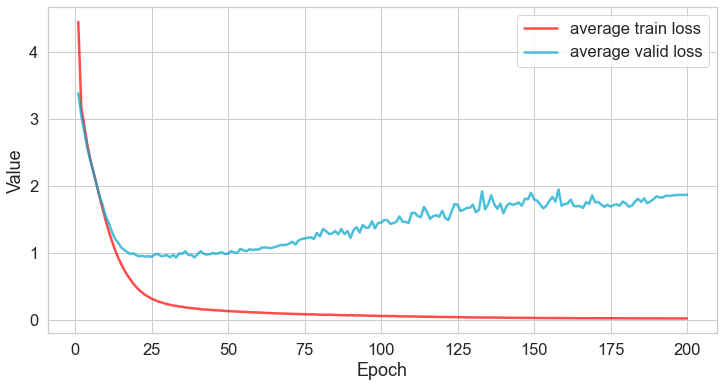

In [81]:
visualize_loss('protac_training_logs/0811/convergence.log')

In [76]:
def visualize_fraction(generation_log_file):
    data = []
    with open(generation_log_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            lst = line.split(',')
            data.append(lst)
    df = pd.DataFrame(data)
    df = df.rename(columns=df.iloc[0])
    df = df.drop(0)
    df = df.drop(1)
    df.columns = df.columns.str.strip()
    df["set"] = df["set"].str[6:].astype(int)

    for x in df.columns[1:]:
        try:
            df[x] = df[x].str.strip().replace("NA",np.nan).astype(float)
        except:
            pass


    plot_df = df[["set","fraction_valid"]]

    sns.set(rc = {'figure.figsize':(12,6)})
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    data_df = pd.melt(plot_df, ["set"])
    x_vals = np.array(data_df['set'].tolist())
    y_vals = np.array(data_df['value'].tolist())


    _ = sns.lineplot(x="set", y="value", hue="variable",  data=data_df, palette=['#00A4CCFF'])
    _.set_xlabel("Epoch")
    _.set_ylabel("Value")
    _.legend(labels=["fraction valid"])

    upper = gaussian_filter1d(y_vals + 0.004, sigma=3)
    lower = gaussian_filter1d(y_vals - 0.004, sigma=3)
    _.fill_between(x_vals, upper, lower, color='red', alpha=0.7)

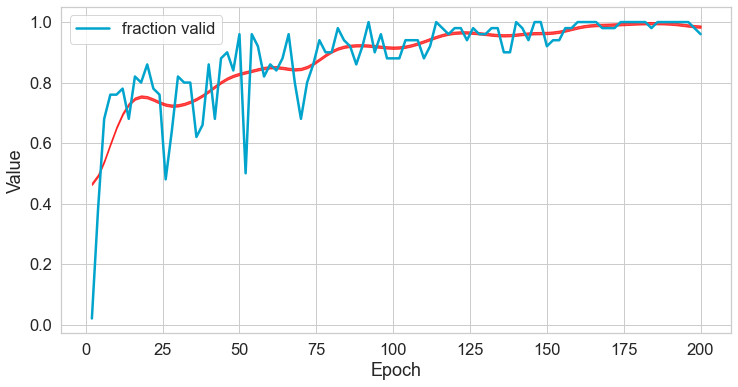

In [77]:
visualize_fraction('protac_training_logs/0811/generation.log')

Molecule Metrics

Regeneration Percentage

In [ ]:
def regen_percent(gen_smi, orig_smi):
    unique = 0
    with open(gen_smi) as file1:
        lines = file1.readlines()
        gen_lines = [line.rstrip() for line in lines]
    with open(orig_smi) as file2:
        lines = file2.readlines()
        orig_lines = [line.rstrip() for line in lines]
    for smi in gen_lines:
        if smi in orig_lines:
            pass
        else:
            unique+=1
    return (len(gen_lines)-unique)/len(gen_lines)

Duplicate Percentage

In [ ]:
def duplicate_percent(gen_smi):
    duplicates = 0
    unique_lst = {}
    with open(gen_smi) as file1:
        lines = file1.readlines()
        gen_lines = [line.rstrip().split()[0] for line in lines]
    for smi in gen_lines:
        if smi in unique_lst:
            duplicates+=1
            unique_lst[smi] +=1
        else:
            unique_lst[smi] = 1
    unique_smi = unique_lst.keys()
    with open('data/generated_protacs_after_finetune/e3_unique_filtered.smi', 'w') as f:
        for smi in unique_smi:
            if len(smi)>70:
                f.write(f"{smi}\n")
    return duplicates/len(gen_lines), unique_lst

Avg N Nodes

In [ ]:
import re
import rdkit
from rdkit import Chem
from statistics import mean
def avg_n_nodes(gen_smi):
    n_counts = []
    with open(gen_smi) as file1:
        lines = file1.readlines()
        gen_lines = [line.rstrip().split()[0] for line in lines]
    for smi in gen_lines:
        if "Xe" not in smi:
            n = Chem.MolFromSmiles(smi).GetNumAtoms()
            n_counts.append(n)
    return mean(n_counts)

In [ ]:
avg_n_nodes('data/protac_train.smi')

Percent Active

In [13]:
from rdkit import Chem
import requests as r
def predictDegradation(mol, cellType='SRD15', receptor='Q9Y616', e3Ligase='CRBN'):
    scoring_model = pickle.load(open('surrogate_model.pkl', 'rb'))
    with open('features.pkl','rb') as fp:
        features = pickle.load(fp)

    ngrams_array = np.zeros((1,7841), dtype=np.int8)
    # baseUrl="http://www.uniprot.org/uniprot/"
    # currentUrl=baseUrl+receptor+".fasta"
    # response = r.post(currentUrl)
    # cData=''.join(response.text)
    # i = cData.index('\n')+1
    # seq = cData[i:].strip().lower()
    seq = "MAGNCGARGALSAHTLLFDLPPALLGELCAVLDSCDGALGWRGLAERLSSSWLDVRHIEKYVDQGKSGTRELLWSWAQKNKTIGDLLQVLQEMGHRRAIHLITNYGAVLSPSEKSYQEGGFPNILFKETANVTVDNVLIPEHNEKGILLKSSISFQNIIEGTRNFHKDFLIGEGEIFEVYRVEIQNLTYAVKLFKQEKKMQCKKHWKRFLSELEVLLLFHHPNILELAAYFTETEKFCLIYPYMRNGTLFDRLQCVGDTAPLPWHIRIGILIGISKAIHYLHNVQPCSVICGSISSANILLDDQFQPKLTDFAMAHFRSHLEHQSCTINMTSSSSKHLWYMPEEYIRQGKLSIKTDVYSFGIVIMEVLTGCRVVLDDPKHIQLRDLLRELMEKRGLDSCLSFLDKKVPPCPRNFSAKLFCLAGRCAATRAKLRPSMDEVLNTLESTQASLYFAEDPPTSLKSFRCPSPLFLENVPSIPVEDDESQNNNLLPSDEGLRIDRMTQKTPFECSQSEVMFLSLDKKPESKRNEEACNMPSSSCEESWFPKYIVPSQDLRPYKVNIDPSSEAPGHSCRSRPVESSCSSKFSWDEYEQYKKE".lower()
    ngrams = features[1238:]
    for i in range(len(ngrams)):
        n = seq.count(ngrams[i])
        ngrams_array[0][i] = n
        
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    fp_array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint, fp_array)

    ct_ind = features.index("ct_"+cellType)
    e3_ind = features.index("e3_"+e3Ligase)

    input = list(0 for i in range(5)) + list(fp_array) + list(0 for i in range(207))+ list(ngrams_array[0])
    input[ct_ind] = 1
    input[e3_ind] = 1

    output = scoring_model.predict([input])
    if output[0][0]-output[0][1] < 0:
        return 1
    else:
        return 0
    #return output[0].argmax()

In [14]:
def score(smi_file):
    # load molecules from file
    mols = SmilesMolSupplier(smi_file, sanitize=True, nameColumn=-1,titleLine=True)
    mols_list = [mol for mol in mols]
    print('created mols list')

    activity_scores = []
    pos_mols_list = []
    neg_mols_list = []
    for m in mols_list:
        if m is None:
            pass
        else:
            s = predictDegradation(m)
            activity_scores.append(s)
            if s>0:
                pos_mols_list.append(m)
            else:
                neg_mols_list.append(m)
    active_percent = sum(activity_scores)/len(activity_scores)
    neg_smi_list = [Chem.MolToSmiles(mol) for mol in neg_mols_list]
    pos_smi_list = [Chem.MolToSmiles(mol) for mol in pos_mols_list]
    return active_percent

In [6]:
score("data/generated_protacs_before_finetune/epoch114_preft_2500_zenodo.smi")

created mols list


0.3473389355742297

In [7]:
score("data/generated_protacs_before_finetune/epoch192_preft_2500_zenodo.smi")

created mols list


0.5078031212484994

In [8]:
score("data/generated_protacs_after_finetune/epoch114_postft_2500_zenodo.smi")

created mols list


0.59343737494998

In [9]:
score("data/generated_protacs_after_finetune/epoch192_postft_10000_zenodo.smi")

RDKit ERROR: [12:29:29] SMILES Parse Error: extra open parentheses for input: 'O=C1CCC(N2C(=O)c3cccc(O'
[12:29:29] SMILES Parse Error: extra open parentheses for input: 'O=C1CCC(N2C(=O)c3cccc(O'


created mols list


0.8381676335267053

Diversity

In [ ]:
from rdkit.DataStructs import FingerprintSimilarity

In [ ]:
similarity = []
for i_mol, smiles_1 in enumerate(['O=C1CCC(N2C(=O)c3cccc(NCCOCCCC(=O)Nc4ccc(N5Cc6ccc(O)cc6OC5=O)cc4)c3C2=O)C(=O)N1','NC1NCC1NC(=O)C1CCN=CCCCCCC(=O)Nc2cccc3c2C(=O)N(C3=O)C2CCC(=O)N1C2=O']):
    mol_similarity = []
    for j_mol, smiles_2 in enumerate(['CCCCCCC(C)C(N)=O','CC(C)(C)C(NC(=O)CCCCC(=O)NCCOCCOCCCCCN1Cc2c(NC(=O)NCCCCCCCCC(=O)NO)cccc2C1=O)C(=O)N1CC(O)CC1C(=O)NCc1ccccc1']):
        if i_mol != j_mol and  smiles_1 and smiles_2 and smiles_1 != "[Xe]" and smiles_2 != "[Xe]":
            mol_1 = Chem.MolFromSmiles(smiles_1)
            mol_2 = Chem.MolFromSmiles(smiles_2)
            mol_similarity.append(FingerprintSimilarity(Chem.RDKFingerprint(mol_1), Chem.RDKFingerprint(mol_2)) )
    similarity.append(mol_similarity) #append mean similarity of smiles_1
mean_similarity = np.mean(np.mean(mol_similarity))

In [3]:
from rdkit.Chem.Scaffolds import MurckoScaffold
def count_murcko_scaffolds(file):
    with open(file) as file1:
        lines = file1.readlines()
        smis = [line.rstrip().split()[0] for line in lines]
    scaffolds = []
    for smi in smis:
        scaffolds.append(MurckoScaffold.MurckoScaffoldSmiles(smi))
    print(len(smis))
    print((len(set(scaffolds))))
    return scaffolds

In [4]:
scaffolds_orig = count_murcko_scaffolds('data/protac/orig.smi')

5152
2907


In [6]:
scaffolds_protac = count_murcko_scaffolds('data/generated_protacs_after_finetune/epoch192_postft.smi')

10000
537


In [8]:
scaffolds_shared = set(scaffolds_orig) & set(scaffolds_protac))

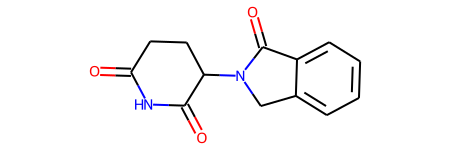

In [1]:
#most common scaffold
Chem.MolFromSmiles('O=C1CCC(N2Cc3ccccc3C2=O)C(=O)N1')

In [36]:
from collections import Counter
scaffolds_to_count = (scaf for scaf in scaffolds_orig if scaf[:1].isupper())
c = Counter(scaffolds_to_count)
orig_most_common = c.most_common(25)
orig_most_common = [x[0] for x in orig_most_common]

In [37]:
from collections import Counter
scaffolds_to_count = (scaf for scaf in scaffolds_protac if scaf[:1].isupper())
c = Counter(scaffolds_to_count)
protac_most_common = c.most_common(25)
protac_most_common = [x[0] for x in protac_most_common]

In [38]:
scaffolds_shared = set(orig_most_common) & set(protac_most_common)

In [39]:
scaffolds_shared

{'O=C1CCC(N2C(=O)c3cccc(NCCCCCCCCN4CCC(NC(=O)c5[nH]ncc5NC(=O)c5ccccc5)CC4)c3C2=O)C(=O)N1',
 'O=C1CCC(N2Cc3ccccc3C2=O)C(=O)N1'}

Drug-Likeness

In [ ]:
from rdkit.Chem import Lipinski

def lipinski_rules(file):
    with open(file) as file1:
        lines = file1.readlines()
        smis = [line.rstrip().split()[0] for line in lines]
    sum_h_acceptors = 0
    sum_h_donors = 0
    for smi in smis:
        sum_h_acceptors += Lipinski.NumHAcceptors(Chem.MolFromSmiles(smi))
        sum_h_donors += Lipinski.NumHDonors(Chem.MolFromSmiles(smi))
    print(f"avg number of hydrogen bond acceptors {sum_h_acceptors/len(smis)}")
    print(f"avg number of hydrogen bond donors {sum_h_donors/len(smis)}")

In [ ]:
lipinski_rules('data/protac/orig.smi')

In [ ]:
lipinski_rules('data/generated_protacs_before_finetune_0810/epoch192_preft.smi')

In [ ]:
lipinski_rules('data/generated_protacs_after_finetune/epoch192_postft.smi')